#### Prepare Dataset
- Install Packages
- Import Packages
- Download Data

##### Install Packages

In [1]:
# pip install copernicus_marine_client
# pip install tensorflow
# pip install tensorflow

In [2]:
# pip install keras-tuner --upgrade

##### Import Packages

In [3]:
import os
import xarray as xr
import copernicus_marine_client as copernicusmarine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
import keras_tuner

2023-12-20 02:14:47.229682: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 02:14:47.232580: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 02:14:47.266005: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 02:14:47.266025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 02:14:47.266930: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

##### Download Data  
- Download data from source website form two dataset_id
- Merge two dataset

In [4]:
# Download data from source website form two dataset_id
copernicusmarine.login("xfeng4","Sf1260358662@") #login, overwrite it ? [y/N]: y

#field name in dataset
data_variables = ["sithick","siconc","thetao","bottomT","so", "usi", "vsi","uo","vo"]

#create folder to store raw data
cwd = os.getcwd()
folder = "sea ice thickness dataset"
site = "greenland" #create dictionary: {site: lat and long range}
folder_path = os.path.join(cwd, folder, site) 
os.makedirs(folder_path, exist_ok=True) 

File /home/jovyan/.copernicus-marine-client/.copernicus-marine-credentials already exists, overwrite it ? [y/N]:

  y


INFO - 2023-12-20T02:14:51Z - Credentials file stored in /home/jovyan/.copernicus-marine-client/.copernicus-marine-credentials.


In [5]:
#first dataset
for var in data_variables:
    output_file = os.path.join(folder_path, f"{var}_id1.nc")
    if os.path.exists(output_file):
        pass
    else:
        copernicusmarine.subset(
          dataset_id="cmems_mod_glo_phy_my_0.083deg_P1D-m",
          variables=[var],
          minimum_longitude=-58.133,
          maximum_longitude=-57.718,
          minimum_latitude=82.892,
          maximum_latitude=83.307,
          start_datetime="1993-01-01T00:00:00",
          end_datetime="2021-06-30T23:59:59",
          output_filename=output_file)

#second dataset ID
for var in data_variables:
    output_file = os.path.join(folder_path, f"{var}_id2.nc")
    if os.path.exists(output_file):
        pass
    else:
        copernicusmarine.subset(
          dataset_id="cmems_mod_glo_phy_myint_0.083deg_P1D-m",
          variables=[var],
          minimum_longitude=-58.133,
          maximum_longitude=-57.718,
          minimum_latitude=82.892,
          maximum_latitude=83.307,
          start_datetime="2021-07-01T00:00:00",
          end_datetime="2023-07-31T23:59:59",
          output_filename=os.path.join(folder_path, f"{var}_id2.nc"))
        
print("down")

down


In [6]:
#Merge two dataset
os.makedirs(os.path.join(folder_path, "Merged"), exist_ok=True) 

for var in data_variables:
    output_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
    if os.path.exists(output_file):
        pass
    else:
        data_id1_file = os.path.join(folder_path, f"{var}_id1.nc")
        data_id2_file = os.path.join(folder_path, f"{var}_id2.nc")
        data_id1_xr = xr.open_dataset(data_id1_file)
        data_id2_xr = xr.open_dataset(data_id2_file)
        data_xr = xr.merge([data_id1_xr, data_id2_xr])
        data_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
        data_xr.to_netcdf(data_file)
        
print("down")

down


#### Process Data
- read as xarray, drop "depth" dimension, and merge xrray
- normalization
- flat data for NN
- time slider for LSTM

##### Read as xarray, drop "depth" dimension, and merge xarray

In [7]:
#extract training_data
#create variable for time slice
training_data = {}
for var in data_variables:
    data_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
    selection_dataset = xr.open_dataset(data_file)
    selection_dataset_time = selection_dataset.sel(time=slice('1993-01-01', '2018-12-31'))

    if 'depth' in selection_dataset_time[var].dims: #drop "depth" if it exists
        selection_dataset_time[var] = selection_dataset_time[var].mean(dim='depth')
        selection_dataset_time = selection_dataset_time.drop_vars("depth")
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans: #complete data via linear interpolate
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')
    else:
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans:
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')

    training_data[var] = selection_dataset_time

#check if dimensions same: only keep time, lat and lon
dimensions = None
for var, dataset in training_data.items():
    if dimensions is None:
        dimensions = dataset.dims
    elif dimensions != dataset.dims:
        raise ValueError(f"Dimension mismatch in variable {var}")

train = xr.merge([training_data[var] for var in data_variables])

#get input and output variables 
x_train_xr = train[["siconc", "thetao", "bottomT", "so", "usi", "vsi", "uo", "vo"]]
y_train_xr = train["sithick"]

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [8]:
#extract testing_data
#write a function for extract and merge
testing_data = {}
for var in data_variables:
    data_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
    selection_dataset = xr.open_dataset(data_file)
    selection_dataset_time = selection_dataset.sel(time=slice('2019-01-01', '2023-07-31'))

    if 'depth' in selection_dataset_time[var].dims:
        selection_dataset_time[var] = selection_dataset_time[var].mean(dim='depth')
        selection_dataset_time = selection_dataset_time.drop_vars("depth")
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans:
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')
    else:
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans:
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')

    testing_data[var] = selection_dataset_time
    
dimensions = None
for var, dataset in testing_data.items():
    if dimensions is None:
        dimensions = dataset.dims
    elif dimensions != dataset.dims:
        raise ValueError(f"Dimension mismatch in variable {var}")

test = xr.merge([testing_data[var] for var in data_variables])

x_test_xr = test[["siconc", "thetao", "bottomT", "so", "usi", "vsi", "uo", "vo"]]
y_test_xr = test["sithick"]

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


##### Normalization

In [9]:
meanstd_inputs = {}
predictors = ["siconc", "thetao", "bottomT", "so", "usi", "vsi", "uo", "vo"]

def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

for var in predictors:
    meanstd_inputs[var] = (x_train_xr[var].data.mean(), x_train_xr[var].data.std())
    
# normalize each variables
for var in predictors:
    # training set
    var_dims   = x_train_xr[var].dims
    x_train_xr = x_train_xr.assign({var: (var_dims, normalize(x_train_xr[var].data, var, meanstd_inputs))})
    
    # test set
    var_dims  = x_test_xr[var].dims
    x_test_xr = x_test_xr.assign({var: (var_dims, normalize(x_test_xr[var].data, var, meanstd_inputs))})

In [10]:
x_train_np  = x_train_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data
x_test_np  = x_test_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data

y_train_np = y_train_xr.data
y_test_np = y_test_xr.data

print(x_train_np.shape, x_test_np.shape, y_train_np.shape, y_test_np.shape)

(9496, 5, 5, 8) (1673, 5, 5, 8) (9496, 5, 5) (1673, 5, 5)


##### Flat data for NN

In [11]:
#convert model to 1D for NN
x_train_flattened = x_train_np.reshape(x_train_np.shape[0], -1)  # x_train.shape[0] is the number of samples
y_train_flattened = y_train_np.reshape(y_train_np.shape[0], -1)
x_test_flattened = x_test_np.reshape(x_test_np.shape[0], -1)

##### Add time slider for LSTM

In [12]:
#adjust dataset to feed LSTM
slider = 5
x_train_slider = np.array([x_train_np[i:i+slider] for i in range(0, x_train_np.shape[0]-slider+1)])
y_train_slider = np.array([y_train_np[i+slider-1] for i in range(0, y_train_np.shape[0]-slider+1)])

x_test_slider = np.array([x_test_np[i:i+slider] for i in range(0, x_test_np.shape[0]-slider+1)])

print(x_train_np.shape, x_train_slider.shape)
print(y_train_np.shape, y_train_slider.shape)
print(x_test_np.shape, x_test_slider.shape)

#stack them to get shape (n_timepoints, n_slider, features)
input_shape = (5, 5, 5, 8)  # time slider, lat, long, features
output_shape = (5, 5)    # lat, long

# Flatten the spatial dimensions for the LSTM input
flattened_spatial_dim = input_shape[1] * input_shape[2] * input_shape[3]

(9496, 5, 5, 8) (9492, 5, 5, 5, 8)
(9496, 5, 5) (9492, 5, 5)
(1673, 5, 5, 8) (1669, 5, 5, 5, 8)


#### Train the model
- NN
- NN + keras_tuner, always excess the limit
- CNN + keras_tuner
- LSTM + keras_tuner
- CNN LSTM + keras_tuner  
*how to do feature selection?*

##### NN

In [13]:
n_neuron       = 64 #the number of n_neuron
activation     = 'relu' #activation methods
num_epochs     = 50 #go through how many times weight adjusted
learning_rate  = 0.001 #related to optimize
minibatch_size = 64 #the way to optimize
model_num      = 1
N_layers       = 2 # number of hidden layers

In [14]:
# mse
model_mse = Sequential()
model_mse.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(x_train_flattened.shape[1],)))
for n in range(N_layers-1):
    model_mse.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model_mse.add(Dense(y_train_flattened.shape[1],  activation='linear', name="output_layer")) # the output layer
model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model_mse.summary()

#mae
model_mae = Sequential()
model_mae.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(x_train_flattened.shape[1],)))
for n in range(N_layers-1):
    model_mae.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model_mae.add(Dense(y_train_flattened.shape[1],  activation='linear', name="output_layer")) # the output layer
model_mae.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model_mae.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                12864     
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 25)                1625      
                                                                 
Total params: 18649 (72.85 KB)
Trainable params: 18649 (72.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                12864     
                                                                

In [15]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

#mse
history_mse = model_mse.fit(x_train_flattened, y_train_flattened, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])
#mae
history_mae = model_mae.fit(x_train_flattened, y_train_flattened, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
119/119 [==============================] - 1s 3ms/step - loss: 4.0692 - val_loss: 0.8559
Epoch 2/50
119/119 [==============================] - 0s 2ms/step - loss: 0.2236 - val_loss: 0.7779
Epoch 3/50
119/119 [==============================] - 0s 1ms/step - loss: 0.1831 - val_loss: 0.7244
Epoch 4/50
119/119 [==============================] - 0s 1ms/step - loss: 0.1603 - val_loss: 0.6580
Epoch 5/50
119/119 [==============================] - 0s 1ms/step - loss: 0.1425 - val_loss: 0.6544
Epoch 6/50
119/119 [==============================] - 0s 2ms/step - loss: 0.1282 - val_loss: 0.4079
Epoch 7/50
119/119 [==============================] - 0s 2ms/step - loss: 0.1164 - val_loss: 0.5223
Epoch 8/50
119/119 [==============================] - 0s 2ms/step - loss: 0.1061 - val_loss: 0.5872
Epoch 9/50
119/119 [==============================] - 0s 2ms/step - loss: 0.1001 - val_loss: 0.7797
Epoch 10/50
119/119 [==============================] - 0s 2ms/step - loss: 0.0952 - val_loss: 0.6647

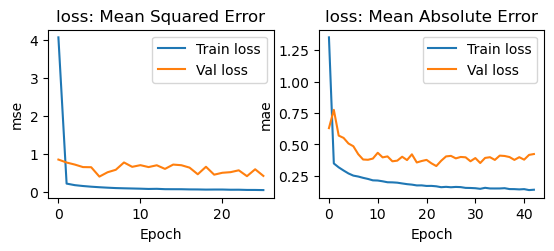

In [16]:
plt.subplot(2, 2, 1)
plt.plot(history_mse.history['loss'])
plt.plot(history_mse.history['val_loss'])
plt.title('loss: Mean Squared Error', fontsize=12)
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

plt.subplot(2, 2, 2)
plt.plot(history_mae.history['loss'])
plt.plot(history_mae.history['val_loss'])
plt.title('loss: Mean Absolute Error', fontsize=12)
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

In [17]:
model_path = os.path.join(cwd,'saved_model')
os.makedirs(model_path, exist_ok=True)
model_mse.save(os.path.join(model_path,'NN_mse_model.h5'))
model_mae.save(os.path.join(model_path, 'NN_mae_model.h5'))

/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### NN + keras tuner

##### CNN + Keras tuner

In [18]:
minibatch_size = 64
num_epochs     = 80
n_trials       = 10   # total number of trials in hyperparameter tuning

In [19]:
def CNN_model(hp):
    
    # options for hyperparameters
    hp_filters = hp.Choice('filters', values=[16,32,64])
    hp_kernel_size = hp.Choice('kernel_size', values=[2,3,4,5])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    
    # build CNN models according to the hyperparameters
    model = keras.models.Sequential()

    model.add(Dense(hp_filters*5*5, input_shape=x_train.shape[1:], activation=hp_activation)) 
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=1, padding='same')) # shape: (5,5,filters)
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=1, padding='same')) # shape: (48,72,filters)
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=1, padding='same')) # shape: (96,144,filters)
    
    model.add(Conv2DTranspose(filters=1, kernel_size=hp_kernel_size, 
                              activation="linear", padding="same")) # shape: (96,144,1)
    
    model.compile(loss=hp_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))
    
    return model

In [20]:
random_tuner = keras_tuner.RandomSearch(CNN_model, 
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search', 
                                        project_name='random_search_CNN_10trials')

Reloading Tuner from random_search/random_search_CNN_10trials/tuner0.json


In [21]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


In [22]:
random_tuner.search(x_train_np, y_train_np,
                    batch_size = minibatch_size,
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [early_stop])

In [23]:
best_model = random_tuner.get_best_models()[0]
best_model.summary()


NameError: name 'x_train' is not defined

In [ ]:
all_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)

# print the hyperparameters of the top 3 tuning trials
for it in range(3):
    print("Ranking #", str(it+1).zfill(1), "of best tuning, total trials = ", str(n_trials))
    print(all_hps[it].values)
    print("=============================================================================================")


# get the hyperparameters of the best tuning trial
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]

# get the hyperparameters of the second ranking tuning trial
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]

In [ ]:
## Build the model with the optimal hyperparameters
# ---------- best tuning ----------
model_best = random_tuner.hypermodel.build(best_hps)

# ---------- ranking #2 tuning ----------
model_top2 = random_tuner.hypermodel.build(top2_hps)



## re-train the model
# ---------- best tuning ----------
history_best = model_best.fit(x_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])
# ---------- ranking #2 tuning ----------
history_top2 = model_top2.fit(x_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])

In [ ]:
## set up title and ylabel strings
# ---------- best tuning ----------
title_best = 'loss: '+str(best_hps['loss'])
ylabel_best = best_hps['loss']
# ---------- ranking #2 tuning ----------
title_top2 = 'loss: '+str(top2_hps['loss'])
ylabel_top2 = top2_hps['loss']


## plot history
# ---------- best tuning ----------
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

# ---------- ranking #2 tuning ----------
plt.subplot(1, 2, 2)
plt.plot(history_top2.history['loss'])
plt.plot(history_top2.history['val_loss'])
plt.title(title_top2, fontsize=12)
plt.ylabel(ylabel_top2)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

In [ ]:
model_path = os.path.join(cwd,'saved_model')
os.makedirs(model_path, exist_ok=True)


In [ ]:
model_best.save(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank1.h5'))
model_top2.save(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank2.h5'))


##### LSTM + keras tuner

In [ ]:
# set hyperparameters
num_epochs     = 50
minibatch_size = 64
n_trials = 12

In [ ]:
def LSTM_model(hp):

    hp_neuron = hp.Choice('filters', values=[32, 64, 128])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    LSTM_model = Sequential()
    LSTM_model.add(Reshape((input_shape[0], flattened_spatial_dim), input_shape=input_shape))
    LSTM_model.add(LSTM(hp_neuron, return_sequences=True, activation=hp_activation))
    LSTM_model.add(LSTM(hp_neuron, return_sequences=False, activation=hp_activation))
    LSTM_model.add(Dense(output_shape[0] * output_shape[1], activation="linear"))
    LSTM_model.add(Reshape(output_shape))

    LSTM_model.compile(loss=hp_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))
    return LSTM_model


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

random_tuner = keras_tuner.RandomSearch(LSTM_model, 
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search', 
                                        project_name='random_search_LSTM_12trials')

In [ ]:
random_tuner.search(x_train_slider, y_train_slider,
                    batch_size = minibatch_size,
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [early_stop])

In [ ]:
# get the hyperparameters of the best tuning trial
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]

# get the hyperparameters of the second ranking tuning trial
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]

In [ ]:
## Build the model with the optimal hyperparameters
# ---------- best tuning ----------
model_best = random_tuner.hypermodel.build(best_hps)

# ---------- ranking #2 tuning ----------
model_top2 = random_tuner.hypermodel.build(top2_hps)



## re-train the model
# ---------- best tuning ----------
history_best = model_best.fit(x_train_slider, y_train_slider,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])
# ---------- ranking #2 tuning ----------
history_top2 = model_top2.fit(x_train_slider, y_train_slider,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])


In [ ]:
## set up title and ylabel strings
# ---------- best tuning ----------
title_best = 'loss: '+str(best_hps['loss'])
ylabel_best = best_hps['loss']
# ---------- ranking #2 tuning ----------
title_top2 = 'loss: '+str(top2_hps['loss'])
ylabel_top2 = top2_hps['loss']


## plot history
# ---------- best tuning ----------
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

# ---------- ranking #2 tuning ----------
plt.subplot(1, 2, 2)
plt.plot(history_top2.history['loss'])
plt.plot(history_top2.history['val_loss'])
plt.title(title_top2, fontsize=12)
plt.ylabel(ylabel_top2)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

In [ ]:
model_path = os.path.join(cwd,'saved_model')
model_best.save(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank1.h5'))
model_top2.save(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank2.h5'))

#### Test Model
- NN
- NN + keras tuner
- CNN + keras tuner
- LSTM + keras tuner
- CNN_LSTM + keras tuner

##### NN

In [ ]:
model_mse = load_model(os.path.join(model_path,'NN_mse_model.h5'))
model_mae = load_model(os.path.join(model_path,'NN_mae_model.h5'))

In [ ]:
y_test_mse_pre = model_mse.predict(x_test_flattened)
y_test_mae_pre = model_mae.predict(x_test_flattened)

In [ ]:
y_test_mse_pre = y_test_mse_pre.reshape(y_test_mse_pre.shape[0], 5, 5)
y_test_mse_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_mse_pre)))

y_test_mae_pre = y_test_mae_pre.reshape(y_test_mae_pre.shape[0], 5, 5)
y_test_mae_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_mae_pre)))


In [ ]:
y_test_mse_pre

In [ ]:
print(y_test_np.shape)
y_test_np = xr.Dataset(coords={'time': y_test_xr.time.values, 
                                     'latitude': y_test_xr.latitude.values, 
                                     'longitude': y_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_np)))

In [ ]:
lat = 83.25
lon = -57.75
#mse
fig, ax = plt.subplots(figsize=(9, 4))
y_test_np.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_mse_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Prediction-mse')

ax.legend()
ax.set_ylabel('Sea ice thickness-mse (m)') 

plt.tight_layout()
plt.show()
#mae
fig, ax = plt.subplots(figsize=(9, 4))
y_test_np.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_mae_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Prediction-mae')

ax.legend()
ax.set_ylabel('Sea ice thickness (m)') 

plt.tight_layout()
plt.show()

In [ ]:
def global_mean_std_plot(X, label, color, ax, var='sithick'):
    weights = np.cos(np.deg2rad(X.latitude))
    sithick_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    sithick_std = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, sithick_mean, label=label, color=color, linewidth=2)
    ax.fill_between(x, sithick_mean+sithick_std, sithick_mean-sithick_std, facecolor=color, alpha=0.2)

In [ ]:
fig,ax = plt.subplots(figsize=(9,4))
#mse
global_mean_std_plot(y_test_np,label='Truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_mse_pre,label='Prediction-mse',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('Sea Ice Thickness (m)')
ax.legend()
plt.tight_layout()

fig,ax = plt.subplots(figsize=(9,4))
#mae
global_mean_std_plot(y_test_np,label='Truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_mae_pre,label='Prediction-mae',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('Sea Ice Thickness (m)')
ax.legend()
plt.tight_layout()

In [ ]:
y_train_np = xr.Dataset(coords={'time': y_train_xr.time.values, 
                                     'latitude': y_train_xr.latitude.values, 
                                     'longitude': y_train_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_train_np)))
y_train_np

In [ ]:
meanstd_outputs = {}
outputs = ["sithick"]

def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    normalized_data = (data - mean) / std
    return normalized_data

for var in outputs:  
    meanstd_outputs[var] = (y_test_np[var].data.mean(), y_test_np[var].data.std())




In [ ]:
for var in outputs:

    # Normalize the test data
    var_dims = y_test_np[var].dims
    y_test_np_nor = y_test_np.assign({var: (var_dims, normalize(y_test_np[var].data, var, meanstd_outputs))})
    
    # Normalize the pre data
    var_dims = y_test_mse_pre.dims
    y_test_mse_pre_nor = y_test_mse_pre.assign({var: (var_dims, normalize(y_test_mse_pre[var].data, var, meanstd_outputs))})
    var_dims = y_test_mae_pre.dims
    y_test_mae_pre_nor = y_test_mae_pre.assign({var: (var_dims, normalize(y_test_mae_pre[var].data, var, meanstd_outputs))})
    
    print(var_dims)

In [ ]:
# specific date
from matplotlib.colors import LinearSegmentedColormap as color

season = ["2020-3-20", "2020-6-21", "2020-9-22", "2020-12-21"]
vmin, vmax = -2, 5
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

#mse
fig, axes = plt.subplots(figsize=(15, 15), ncols=2, nrows=4)  
for i, date in enumerate(season):
    y_test_mse_pre.sithick.sel(time=date).plot(ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
    y_test_np.sithick.sel(time=date).plot(ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(f'Sea Ice Thickness Model Prediction ({date})-mse', fontweight='bold')
    axes[i, 1].set_title(f'Sea Ice Thickness Truth ({date})-mse', fontweight='bold')

plt.tight_layout()
plt.show()

#mae
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=4)
for i, date in enumerate(season):
    y_test_mae_pre.sithick.sel(time=date).plot(ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
    y_test_np.sithick.sel(time=date).plot(ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(f'Sea Ice Thickness Model Prediction ({date})-mae', fontweight='bold')
    axes[i, 1].set_title(f'Sea Ice Thickness Truth ({date})-mae', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# 2020 average
vmin, vmax = 2, 4
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

# MSE
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

mse_2020_mean = y_test_mse_pre.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_np.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

mse_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-mse', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

# MAE
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

mae_2020_mean = y_test_mae_pre.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_np.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

mae_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-mae', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# with normalization specific date


season = ["2020-3-20", "2020-6-21", "2020-9-22", "2020-12-21"]
vmin, vmax = -3, 3
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

#mse
fig, axes = plt.subplots(figsize=(15, 15), ncols=2, nrows=4)  
for i, date in enumerate(season):
    y_test_mse_pre_nor.sithick.sel(time=date).plot(ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
    y_test_np_nor.sithick.sel(time=date).plot(ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(f'Sea Ice Thickness Model Prediction ({date})-mse', fontweight='bold')
    axes[i, 1].set_title(f'Sea Ice Thickness Truth ({date})-mse', fontweight='bold')

plt.tight_layout()
plt.show()

#mae
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=4)
for i, date in enumerate(season):
    y_test_mae_pre_nor.sithick.sel(time=date).plot(ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
    y_test_np_nor.sithick.sel(time=date).plot(ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(f'Sea Ice Thickness Model Prediction ({date})-mae', fontweight='bold')
    axes[i, 1].set_title(f'Sea Ice Thickness Truth ({date})-mae', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# with normalization 2020 average

vmin, vmax = -3, 1
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

# MSE
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

mse_2020_mean = y_test_mse_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_np_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

mse_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-mse', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

# MAE
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

mae_2020_mean = y_test_mae_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_np_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

mae_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-mae', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

##### CNN + keras tuner

In [ ]:
## reload the saved model
model_best = load_model(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank1.h5'))
model_top2 = load_model(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank2.h5'))


In [ ]:
y_test_best_pre = model_best.predict(x_test_np)
y_test_best_pre = y_test_best_pre.reshape(y_test_best_pre.shape[0], 5, 5)
y_test_best_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_best_pre)))
# ---------- rank #2 tuning ----------
y_test_top2_pre = model_top2.predict(x_test_np)
y_test_top2_pre = y_test_top2_pre.reshape(y_test_top2_pre.shape[0], 5, 5)
y_test_top2_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_top2_pre)))


In [ ]:
y_test_best_pre = xr.Dataset(coords={'time': y_test_best_pre.time.values, 
                                     'latitude': y_test_best_pre.latitude.values, 
                                     'longitude': y_test_best_pre.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_best_pre)))
y_test_top2_pre = xr.Dataset(coords={'time': y_test_top2_pre.time.values, 
                                     'latitude':y_test_top2_pre.latitude.values, 
                                     'longitude': y_test_top2_pre.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_top2_pre)))

In [ ]:
print(y_test_best_pre)
lat = 83.25
lon = -57.75
#best
fig, ax = plt.subplots(figsize=(9, 4))
y_test_np.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_best_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Prediction-best')

ax.legend()
ax.set_ylabel('Sea ice thickness-mse (m)') 

plt.tight_layout()
plt.show()
#top2
fig, ax = plt.subplots(figsize=(9, 4))
y_test_np.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_top2_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Prediction-top2')

ax.legend()
ax.set_ylabel('Sea ice thickness (m)') 

plt.tight_layout()
plt.show()

In [ ]:
def global_mean_std_plot(X, label, color, ax, var='sithick'):
    weights = np.cos(np.deg2rad(X.latitude))
    sithick_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    sithick_std = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, sithick_mean, label=label, color=color, linewidth=2)
    ax.fill_between(x, sithick_mean+sithick_std, sithick_mean-sithick_std, facecolor=color, alpha=0.2)
fig,ax = plt.subplots(figsize=(9,4))
#mse
global_mean_std_plot(y_test_np,label='Truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_best_pre,label='Prediction-best',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('Sea Ice Thickness (m)')
ax.legend()
plt.tight_layout()

fig,ax = plt.subplots(figsize=(9,4))
#mae
global_mean_std_plot(y_test_np,label='Truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_top2_pre,label='Prediction-top2',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('Sea Ice Thickness (m)')
ax.legend()
plt.tight_layout()

In [ ]:
meanstd_outputs = {}
outputs = ["sithick"]

def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    normalized_data = (data - mean) / std
    return normalized_data

for var in outputs:  
    meanstd_outputs[var] = (y_test_np[var].data.mean(), y_test_np[var].data.std())

In [ ]:
print(y_test_best_pre)

In [ ]:
for var in outputs:  
    
    print(f"Working on variable: {var}")
    print("Contents of meanstd_outputs dictionary:", meanstd_outputs)
    
    # Normalize the pre data
    var_dims = y_test_best_pre.dims
    y_test_best_pre_nor = y_test_best_pre.assign({var: (var_dims, normalize(y_test_best_pre[var].data, var, meanstd_outputs))})
    var_dims = y_test_top2_pre.dims
    y_test_top2_pre_nor = y_test_top2_pre.assign({var: (var_dims, normalize(y_test_top2_pre[var].data, var, meanstd_outputs))})

In [ ]:
# specific date
from matplotlib.colors import LinearSegmentedColormap as color

season = ["2020-3-20", "2020-6-21", "2020-9-22", "2020-12-21"]
vmin, vmax = -2, 5
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

#best
fig, axes = plt.subplots(figsize=(15, 15), ncols=2, nrows=4)  
for i, date in enumerate(season):
    y_test_best_pre.sithick.sel(time=date).plot(ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
    y_test_np.sithick.sel(time=date).plot(ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(f'Sea Ice Thickness Model Prediction ({date})-best', fontweight='bold')
    axes[i, 1].set_title(f'Sea Ice Thickness Truth ({date})', fontweight='bold')

plt.tight_layout()
plt.show()

#top2
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=4)
for i, date in enumerate(season):
    y_test_top2_pre.sithick.sel(time=date).plot(ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
    y_test_np.sithick.sel(time=date).plot(ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(f'Sea Ice Thickness Model Prediction ({date})-top2', fontweight='bold')
    axes[i, 1].set_title(f'Sea Ice Thickness Truth ({date})-top2', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# 2020 average
vmin, vmax = 2, 4
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

# MSE
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2020_mean = y_test_best_pre.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_np.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

best_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-best', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

# MAE
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2020_mean = y_test_top2_pre.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_np.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

top2_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-top2', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# with normalization specific date

season = ["2020-3-20", "2020-6-21", "2020-9-22", "2020-12-21"]
vmin, vmax = -3, 3
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

#best
fig, axes = plt.subplots(figsize=(15, 15), ncols=2, nrows=4)  
for i, date in enumerate(season):
    y_test_best_pre_nor.sithick.sel(time=date).plot(ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
    y_test_np_nor.sithick.sel(time=date).plot(ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(f'Sea Ice Thickness Model Prediction ({date})-best', fontweight='bold')
    axes[i, 1].set_title(f'Sea Ice Thickness Truth ({date})', fontweight='bold')

plt.tight_layout()
plt.show()

#top2
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=4)
for i, date in enumerate(season):
    y_test_top2_pre_nor.sithick.sel(time=date).plot(ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
    y_test_np_nor.sithick.sel(time=date).plot(ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(f'Sea Ice Thickness Model Prediction ({date})-top2', fontweight='bold')
    axes[i, 1].set_title(f'Sea Ice Thickness Truth ({date})', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# with normalization 2020 average

vmin, vmax = -3, 1
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

# best
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2020_mean = y_test_best_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_np_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

best_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-best', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

# top2
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2020_mean = y_test_top2_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_np_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

top2_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-top2', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

##### LSTM + keras tuner

In [ ]:
## reload the saved model
model_best = load_model(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank1.h5'))
model_top2 = load_model(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank2.h5'))


In [ ]:
y_test_best_pre = model_best.predict(x_test_slider)
y_test_best_pre = y_test_best_pre.reshape(y_test_best_pre.shape[0], 5, 5)
y_test_best_pre = xr.Dataset(coords={'time': x_test_xr.time.values[slider-1:], 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_best_pre)))
# ---------- rank #2 tuning ----------
y_test_top2_pre = model_top2.predict(x_test_slider)
y_test_top2_pre = y_test_top2_pre.reshape(y_test_top2_pre.shape[0], 5, 5)
y_test_top2_pre = xr.Dataset(coords={'time': x_test_xr.time.values[slider-1:], 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_top2_pre)))

In [ ]:
graph

In [ ]:
print(y_test_best_pre)
lat = 83.25
lon = -57.75
#best
fig, ax = plt.subplots(figsize=(9, 4))
y_test_np.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_best_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Prediction-best')

ax.legend()
ax.set_ylabel('Sea ice thickness-mse (m)') 

plt.tight_layout()
plt.show()
#top2
fig, ax = plt.subplots(figsize=(9, 4))
y_test_np.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Truth')
y_test_top2_pre.sel(latitude=lat, longitude=lon, method='nearest')["sithick"].plot(ax=ax, label='Prediction-top2')

ax.legend()
ax.set_ylabel('Sea ice thickness (m)') 

plt.tight_layout()
plt.show()

In [ ]:
def global_mean_std_plot(X, label, color, ax, var='sithick'):
    weights = np.cos(np.deg2rad(X.latitude))
    sithick_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    sithick_std = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, sithick_mean, label=label, color=color, linewidth=2)
    ax.fill_between(x, sithick_mean+sithick_std, sithick_mean-sithick_std, facecolor=color, alpha=0.2)
fig,ax = plt.subplots(figsize=(9,4))
#mse
global_mean_std_plot(y_test_np,label='Truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_best_pre,label='Prediction-best',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('Sea Ice Thickness (m)')
ax.legend()
plt.tight_layout()

fig,ax = plt.subplots(figsize=(9,4))
#mae
global_mean_std_plot(y_test_np,label='Truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_top2_pre,label='Prediction-top2',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('Sea Ice Thickness (m)')
ax.legend()
plt.tight_layout()

In [ ]:
meanstd_outputs = {}
outputs = ["sithick"]

def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    normalized_data = (data - mean) / std
    return normalized_data

for var in outputs:  
    meanstd_outputs[var] = (y_test_np[var].data.mean(), y_test_np[var].data.std())

for var in outputs:  

    print(f"Working on variable: {var}")
    print("Contents of meanstd_outputs dictionary:", meanstd_outputs)

    # Normalize the pre data
    var_dims = y_test_best_pre.dims
    y_test_best_pre_nor = y_test_best_pre.assign({var: (var_dims, normalize(y_test_best_pre[var].data, var, meanstd_outputs))})
    var_dims = y_test_top2_pre.dims
    y_test_top2_pre_nor = y_test_top2_pre.assign({var: (var_dims, normalize(y_test_top2_pre[var].data, var, meanstd_outputs))})

In [ ]:
# specific date
from matplotlib.colors import LinearSegmentedColormap as color

season = ["2020-3-20", "2020-6-21", "2020-9-22", "2020-12-21"]
vmin, vmax = -0, 5
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

#best
fig, axes = plt.subplots(figsize=(15, 15), ncols=2, nrows=4)  
for i, date in enumerate(season):
    y_test_best_pre.sithick.sel(time=date).plot(ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
    y_test_np.sithick.sel(time=date).plot(ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(f'Sea Ice Thickness Model Prediction ({date})-best', fontweight='bold')
    axes[i, 1].set_title(f'Sea Ice Thickness Truth ({date})', fontweight='bold')

plt.tight_layout()
plt.show()

#top2
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=4)
for i, date in enumerate(season):
    y_test_top2_pre.sithick.sel(time=date).plot(ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
    y_test_np.sithick.sel(time=date).plot(ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(f'Sea Ice Thickness Model Prediction ({date})-top2', fontweight='bold')
    axes[i, 1].set_title(f'Sea Ice Thickness Truth ({date})-top2', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# 2020 average
vmin, vmax = 2, 4
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

# MSE
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2020_mean = y_test_best_pre.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_np.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

best_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-best', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

# MAE
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2020_mean = y_test_top2_pre.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_np.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

top2_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)

axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-top2', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# with normalization specific date

season = ["2020-3-20", "2020-6-21", "2020-9-22", "2020-12-21"]
vmin, vmax = -3, 3
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

#best
fig, axes = plt.subplots(figsize=(15, 15), ncols=2, nrows=4)  
for i, date in enumerate(season):
    y_test_best_pre_nor.sithick.sel(time=date).plot(ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
    y_test_np_nor.sithick.sel(time=date).plot(ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(f'Sea Ice Thickness Model Prediction ({date})-best', fontweight='bold')
    axes[i, 1].set_title(f'Sea Ice Thickness Truth ({date})', fontweight='bold')

plt.tight_layout()
plt.show()

#top2
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=4)
for i, date in enumerate(season):
    y_test_top2_pre_nor.sithick.sel(time=date).plot(ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
    y_test_np_nor.sithick.sel(time=date).plot(ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap)
    axes[i, 0].set_title(f'Sea Ice Thickness Model Prediction ({date})-top2', fontweight='bold')
    axes[i, 1].set_title(f'Sea Ice Thickness Truth ({date})', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# with normalization 2020 average

vmin, vmax = -2, 2
colors = ["navy", "dodgerblue","white"]
cmap = color.from_list("custom_cmap", colors)

# best
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

best_2020_mean = y_test_best_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_np_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

best_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-best', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()

# top2
fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

top2_2020_mean = y_test_top2_pre_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')
np_2020_mean = y_test_np_nor.sithick.sel(time=slice("2020-01-01", "2020-12-31")).mean(dim='time')

top2_2020_mean.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
np_2020_mean.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Sea Ice Thickness Model Prediction (2020 Average)-top2', fontweight='bold')
axes[1].set_title('Sea Ice Thickness Truth (2020 Average)', fontweight='bold')

plt.tight_layout()
plt.show()